## 5.1 Evaluating generative text models

### 5.1.1 Using GPT to generate text

GPT-2 used tensorflow, but tensorflow is not so popular nowadays

In [1]:
from modules import GPTModel
import torch

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [3]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # eval disables all random numbers
# e.g., dropout, don't want random behaviour during inference
# semicomma disables output
# opposite of eval is train

In [4]:
import tiktoken
from modules import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor


In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = text_to_token_ids(start_context, tokenizer)
token_ids

tensor([[6109, 3626, 6100,  345]])

In [6]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you'

In [7]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

In [8]:
token_ids # 4 input + 10 new

tensor([[ 6109,  3626,  6100,   345, 34245,  5139,  2492, 25405, 17434, 17853,
          5308,  3398, 13174, 43071]])

In [9]:
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

Before training, need a numeric way of visualization\
How to quantify?\
How to meassure how good it is?

### 5.1.2 Calculating the text generation loss: cross-entropy and perplexity

In [10]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

target is shifted by 1 token

In [11]:
with torch.no_grad():
    logits = model(inputs)

In [12]:
logits.shape

torch.Size([2, 3, 50257])

2 - rows; 3 - tokens each; 50257 - vocab size

In [13]:
probas = torch.softmax(logits, dim=-1)

probas.shape

torch.Size([2, 3, 50257])

In [14]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [15]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [16]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])


In [17]:
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


ouput of probabilities\
ideally, want to train them to approach 90%, i.e., model learns to associate generated probability corresponding to text targets to be very large

In [18]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2))) # concate so it's easy to apply same computation
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


The final cross-entropy loss (negative log probability)

In [19]:
-1*torch.mean(log_probas)

tensor(10.7940)

In [20]:
logits.shape

torch.Size([2, 3, 50257])

In [21]:
logits_flat = logits.flatten(0, 1)
logits_flat.shape

torch.Size([6, 50257])

In [22]:
targets_flat = targets.flatten()
targets_flat.shape

torch.Size([6])

In [23]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
loss

tensor(10.7940)

Perplexity

In [24]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


describe how unsure;\
can be understood as the effective vocabulary size that the model is uncertain about at each step (in example, model is sure about no word)

### 5.1.3 Calculating the training and validation set losses

In [25]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [26]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Now divide it into a training set and a small validation set (evaluation and check if overfitting);\
Then divide set into boxes with size of context_length;
then subdivide boxes into batches, batches are shuffled

In [27]:
from modules import create_dataloader_v1
# Alternatively:
# from llms_from_scratch.ch02 import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90 # 10% for validation
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [28]:
print("Train loader:")
for x, y in train_loader:
    pass
print(x.shape, y.shape) # to make sure no error

print("\nValidation loader:")
for x, y in val_loader:
    pass
print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [29]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


last 25 tokens are dropped\
each batch is of same size so won't have weird loss spikes during trining

In [30]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [31]:
torch.cuda.is_available()

True

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.98110580444336


## 5.2 Training an LLM

In [33]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device) # encode sample to token ids
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer) # translate to text
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [34]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

In reality, when training a real new network, like Gemma3, deepseek, they train on 14, 15 trillion tokens\
since the novel is short, 1 epoch is not enough to learn\
normally train 1 or 1.5 epoch max

In [35]:
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.823, Val loss 9.932
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.621, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.043, Val loss 6.599
Every effort moves you, and,, and,, and,,,, and, and,,,,,,,,, and,,,, the,,,, and,, and,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.547, Val loss 6.485
Ep 3 (Step 000025): Train loss 5.450, Val loss 6.397
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.982, Val loss 6.301
Ep 4 (Step 000035): Train loss 4.755, Val loss 6.296
Every effort moves you, and I had been the of the picture to the picture.                                     
Ep 5 (Step 000040): Train loss 4.162, Val loss 6.182
Every effort moves you know the                                                

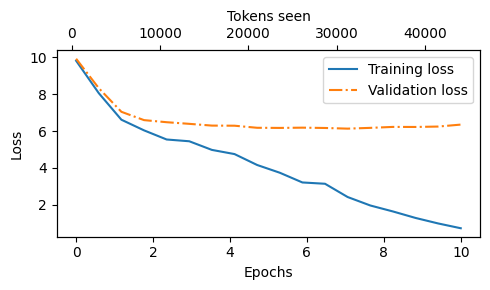

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 5.3 Decoding strategies to control randomness

sampling strategy: top K or top P sampling and temperature scaling

generate text simple just make model to remember words

In [38]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### 5.3.1 Temperature scaling

In [39]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

In [40]:
inverse_vocab = {v: k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [41]:
# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
# deliberately given

In [42]:
probas = torch.softmax(next_token_logits, dim=-1)

In [43]:
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [45]:
inverse_vocab[next_token_id]

'forward'

not always most likely, but randomly

In [61]:
# torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
inverse_vocab[next_token_id]

'toward'

In [62]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


temperature scaling\
modify the distribution

In [63]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

In [65]:
temperatures = [1, 0.1, 5]

In [66]:
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

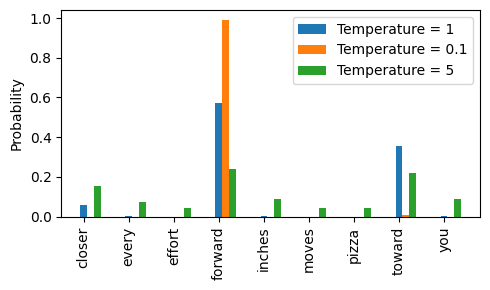

In [67]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

### 5.3.2 Top-k sampling

only leave the k token with highest probability, mask out other with -inf\
so llm will not generate nonsense\
a hyperparameter
reality, 50, 100, 500

In [68]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print(top_logits, top_pos)

tensor([6.7500, 6.2800, 4.5100]) tensor([3, 7, 0])


In [70]:
next_token_logits

tensor([ 4.5100,  0.8900, -1.9000,  6.7500,  1.6300, -1.6200, -1.8900,  6.2800,
         1.7900])

In [71]:
new_logits = torch.where(
    condition=(next_token_logits < top_logits[-1]),
    input=torch.tensor(float("-inf")),
    other=next_token_logits,
)
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])

In [72]:
torch.softmax(new_logits, dim=-1)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])

### 5.3.3 Modifying the text generation function

In [82]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] # truncating

        with torch.no_grad(): # pytorch always builds cal. graph at background
            logits = model(idx_cond)
        logits = logits[:, -1, :] # last row

        if top_k != None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            new_logits = torch.where(
                condition=(next_token_logits < min_val),
                input=torch.tensor(float("-inf")),
                other=next_token_logits,
            )

        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probas, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [83]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youenegger rendering GroundTemp aTweet laterbanks sanctions不 redu portraitition added placed


in reality, with model card suggests some settings for top-k, top-p, temperature

## 5.4 Loading and saving model weights in PyTorch

In [85]:
torch.save(model.state_dict(), "model.pth")

only save parameters, not architecture\
postfix is random, pth is just a convention

In [ ]:
# load weights
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load("model.pth", map_location=device))

## 5.5 Loading pretrained weights from OpenAI

In [1]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


CHOOSE_MODEL = "gpt2-small (124M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

import os
import urllib.request

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")

import torch
from modules import GPTModel
# For llms_from_scratch installation instructions, see:
# https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg


gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);

Downloaded to gpt2-small-124M.pth


no other llm uses bias

In [2]:
import tiktoken
from modules import generate, text_to_token_ids, token_ids_to_text


torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate(
    model=gpt.to(device),
    idx=text_to_token_ids("Every effort moves", tokenizer).to(device),
    max_new_tokens=30,
    context_size=BASE_CONFIG["context_length"],
    top_k=1,
    temperature=1.0
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

ImportError: cannot import name 'generate' from 'modules' (E:\py_project\TorchStudy\LLM-from-scratch\GPT-2-from-scratch\modules.py)